# **Data Mining I | <span style="color: darkseagreen;">Exploratory Data Analysis and Pre-Processing</span>**

## A Clustering-Based Exploration of WorkplaceAbsence Patterns

*Group 07*

*Group members* : Francisco Gomes (20221810), Margarida Marchão (20221901), Pedro Coimbras (20211573) and Marta Alves (20221890).

# Table of Contents

<span style="color:red">isto ainda não é clicable, so uma indicação</span>.

- [Data Mining I — Exploratory Data Analysis and Pre-Processing](#data-mining-i--exploratory-data-analysis-and-pre-processing)
- [1. Importing the datasets and libraries](#1-importing-the-datasets-and-libraries)
- [2. Preliminary Data Analysis](#2-preliminary-data-analysis)  
    - [2.1. Data Types](#21-data-types)  
    - [2.4. Missing Values Analysis](#24-missing-values-analysis)  
    - [2.5. Summary Statistics - (numerical data)](#25-summary-statistics---numerical-data)  
    - [2.6. Findings in the Categorical Data](#26-findings-in-the-categorical-data)  
    - [2.7. Duplicates](#27-duplicates)
- [3. Feature Engineering and Transformation](#3-feature-engineering-and-transformation)  
    - [3.1. Handle identified missing values](#31-handle-identified-missing-values)  
    - [3.2. Handle identified duplicate values](#32-handle-identified-duplicate-values)  
    - [3.3. Feature transformation](#33-feature-transformation)  
    - [3.4. Feature Engineering and selection](#34-feature-engineering-and-selection)  
    - [3.5. Worker-first table](#35-worker-first-table)
- [Appendix / Utilities (helpers, diagnostics)](#appendix--utilities)

<a id="1"></a>

# **1. Importing the datasets and libraries <font>**

In [1]:
#imports
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pylab import rcParams
from sklearn.impute import KNNImputer

from utils1 import (
    calculate_percentage,
    analyze_missingness_patterns,
    diagnose_seasons_from_month,
    secret_missing_values,
)

pd.set_option("display.max_columns", None)

In [2]:
from pathlib import Path

#from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# path = '/content/drive/MyDrive/Colab Notebooks/DM1/projeto/data/'
path2 = 'data/absenteeism_data.csv'
if not Path(path2).exists():
    # Try to find the file in parent directories
    for parent in Path().absolute().parents:
        candidate = parent / path2
        if candidate.exists():
            path2 = str(candidate)
            break


print("Using dataset path:", path2)

Using dataset path: c:\Users\Marta\Desktop\Marta\master\data mining\projeto\reasons_for_absenteeism\data\absenteeism_data.csv


<a id="1"></a>

# **2. Preliminary Data Analysis<font>**

In [3]:
pd.set_option("display.max_columns", None)
#abs = pd.read_csv(path2 + 'absenteeism_data.csv',delimiter=';')
abs = pd.read_csv(path2, delimiter=';')
# abs = abs.set_index("ID")
abs.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,Years until retirement,Date of Birth,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours
0,11,Unjustified absence,July,Tuesday,Summer,0.0,289,36,69,13,32,1992-08-15,No,1,2,Y,No,1,90,172,30,4
1,36,Unspecified,July,Tuesday,NaN,0.0,118,13,26,18,15,1975-09-02,Yes,1,1,Y,No,0,98,178,31,0
2,3,Medical consultation,July,Wednesday,Summer,0.0,179,51,108,18,27,1987-04-08,No,1,0,Yes,No,0,89,170,31,2
3,7,Diseases of the eye and adnexa,July,Thursday,NaN,0.0,279,5,5,14,26,1986-07-25,No,1,2,Yes,Yes,0,68,168,24,4
4,11,Medical consultation,July,Thursday,Summer,0.0,289,36,69,13,32,1992-08-15,No,1,2,Yes,No,1,90,172,30,2


#### **Feature Groups Overview**

| **Category** | **Feature Name** | **Description / Notes** |
|---------------|------------------|--------------------------|
| **Absence Information** | Reason for absence | Registered reason for each absence |
|  | Month of absence | Month when the absence occurred |
|  | Day of the week | Weekday of the absence (Monday–Friday) |
|  | Seasons | Season in which the absence occurred |
|  | Days since previous absence | Number of days since last absence |
|  | Absenteeism time in hours | Duration of absence (in hours) |
| **Commute & Transportation** | Transportation expense | Monthly commuting expenses (BRL) |
|  | Distance from Residence to Work | Distance between home and workplace |
|  | Estimated commute time | Estimated duration of daily commute |
| **Work-Related Features** | Service time | Years worked at the company |
|  | Years until retirement | Years remaining until retirement eligibility |
|  | Disciplinary failure | Whether absence violated company policy (binary) |
| **Demographics & Personal Info** | Date of Birth → *Age* | Employee’s date of birth (convert to age) |
|  | Education | Education level (1–High School → 4–Master’s/PhD) |
|  | Number of children | Total number of children |
|  | Social smoker | Smokes socially (binary) |
|  | Social drinker | Drinks socially (binary) |
|  | Number of pets | Number of pets owned |
| **Health & Physical Attributes** | Weight | Weight (kg) |
|  | Height | Height (cm) |
|  | Body mass index (BMI) | Calculated from height and weight |


In [4]:
# Display unique values for each column
for col in abs.columns:
    unique_vals = abs[col].unique()
    n_unique = len(unique_vals)
    print(f"\n{col} — {n_unique} unique values")
    print(unique_vals[:30])


ID — 36 unique values
[11 36  3  7 10 20 14  1 24  6 33 18 30  2 19 27 34  5 15 29 28 13 22 17
 31 23 32  9 26 21]

Reason for absence — 29 unique values
['Unjustified absence' 'Unspecified' 'Medical consultation'
 'Diseases of the eye and adnexa' 'Patient follow-up'
 'Injury, poisoning and other consequences of external causes'
 'Certain infectious and parasitic diseases' nan
 'Diseases of the digestive system' 'Diseases of the genitourinary system'
 'Factors influencing health status and contact with health services'
 'Diseases of the respiratory system'
 'Diseases of the musculoskeletal system and connective tissue'
 'Dental consultation'
 'Symptoms, signs and abnormal clinical and laboratory findings'
 'Laboratory examination' 'Blood donation'
 'Diseases of the nervous system' 'Physiotherapy'
 'Congenital malformations, deformations and chromosomal abnormalities'
 'Diseases of the ear and mastoid process'
 'Diseases of the skin and subcutaneous tissue'
 'Mental and behavioural dis

In [5]:
display(abs.shape)

(800, 22)

| **Type** | **Count** |
|-----------|-----------|
| Observations (rows) | 800 |
| Variables (columns) | 21 |

Each record corresponds to **one employee’s absence instance**, including personal, work, commute, and health-related information.



<a id="1"></a>

### **2.1. Data Types <font>**

In [ ]:
abs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               800 non-null    int64  
 1   Reason for absence               740 non-null    object 
 2   Month of absence                 737 non-null    object 
 3   Day of the week                  740 non-null    object 
 4   Seasons                          573 non-null    object 
 5   Days since previous absence      781 non-null    float64
 6   Transportation expense           800 non-null    int64  
 7   Distance from Residence to Work  800 non-null    int64  
 8   Estimated commute time           800 non-null    int64  
 9   Service time                     800 non-null    object 
 10  Years until retirement           800 non-null    int64  
 11  Date of Birth                    800 non-null    object 
 12  Disciplinary failure  

None

 - missing values in: reason of absence, month of absence, day of the week, seasons, days since previous absence
 - education is int
 - we can predict seasons with month of absence
 - transportation expense is in brasilian reais -> mudar para euros
 - service time and weight has missing values '-' -> mudar para int
 - one hot no disciplinary failure, social drinker and smoker
 - social drinker and smoker has values of 'Y'
 - ver 0s na coluna do absenteeism time in hours -> 0h can mean 30min or it wasnt absent
 - maybe mudar int64 para int32
 - dar drop do days since previous absence porque só tem um unico valor que é 0.0
 - ver outliers
 - compute age
 - há duplicates - 48
 - -1 no years until retirment pode ser menos de um ano ate reforma, mas unlikely visto que porque as pessoas mais velhas têm por volta dos 50

<a id="1"></a>

### **2.4. Missing Values Analysis <font>**

In [7]:
abs.isna().sum()

ID                                   0
Reason for absence                  60
Month of absence                    63
Day of the week                     60
Seasons                            227
Days since previous absence         19
Transportation expense               0
Distance from Residence to Work      0
Estimated commute time               0
Service time                         0
Years until retirement               0
Date of Birth                        0
Disciplinary failure                 0
Education                            0
Number of children                   0
Social drinker                       0
Social smoker                        0
Number of pets                       0
Weight                               0
Height                               0
Body mass index                      0
Absenteeism time in hours            0
dtype: int64

In [8]:
missing_columns = ['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Days since previous absence']
missing_percentages = calculate_percentage(abs, columns=missing_columns)

for col, percent in missing_percentages.items():
    display(f'Around {percent}% of the data points in the column {col} are missing values')

'Around 7.5% of the data points in the column Reason for absence are missing values'

'Around 7.9% of the data points in the column Month of absence are missing values'

'Around 7.5% of the data points in the column Day of the week are missing values'

'Around 28.4% of the data points in the column Seasons are missing values'

'Around 2.4% of the data points in the column Days since previous absence are missing values'

estamos a ver o porque de algumas variaves serem object ------------------------------------------------------------------------------

| **Column** | **Missing Values** | **Missing (%)** | **Notes / Observations** |
|-------------|--------------------|-----------------|---------------------------|
| Reason for absence | 60 | 7.5% | Moderate number of missing entries — may relate to data entry issues or unclassified absences |
| Month of absence | 63 | 7.9% | Slightly higher missing ratio; may correspond to missing absence dates |
| Day of the week | 60 | 7.5% | Matches missing patterns in "Reason for absence" — possibly same missing records |
| Seasons | 227 | 28.4% | **Highest missing rate**; may require imputation or removal |
| Days since previous absence | 19 | 2.4% | Minor; mostly zeros, might not significantly impact clustering |
| **All other columns** | 0 | 0% | Fully complete |

In [9]:
cols_absence = ['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Days since previous absence']
missing_summary = analyze_missingness_patterns(abs, cols_absence)

Pairwise Missingness Correlation Matrix:


,Reason for absence,Month of absence,Day of the week,Seasons,Days since previous absence
Reason for absence,1.00,0.97,1.00,0.45,-0.04
Month of absence,0.97,1.00,0.97,0.45,-0.05
Day of the week,1.00,0.97,1.00,0.45,-0.04
Seasons,0.45,0.45,0.45,1.00,-0.03
Days since previous absence,-0.04,-0.05,-0.04,-0.03,1.00



 Rows with all of Reason/Month/Day missing: 60

 Top 10 Pairs with Highest Overlapping Missing Values:


count
Month of absence   Seasons                         62
Reason for absence Month of absence                60
                   Day of the week                 60
                   Seasons                         60
Month of absence   Day of the week                 60
Day of the week    Seasons                         60
Seasons            Days since previous absence      4
Reason for absence Days since previous absence      0
Month of absence   Days since previous absence      0
Day of the week    Days since previous absence      0


Example indices where Reason/Month/Day are all missing:


Int64Index([ 11,  13,  16,  29,  49,  68,  81,  83, 124, 130, 142, 154, 175,
            183, 198, 247, 250, 269, 278, 292],
           dtype='int64')

### Missingness Correlation Analysis

| Variable Pair | Correlation | Interpretation |
|----------------|-------------|----------------|
| Reason ↔ Month | 0.97 | Strongly correlated missingness |
| Reason ↔ Day | 1.00 | Identical missing rows |
| Month ↔ Day | 0.97 | Same missing pattern |
| Reason/Month/Day ↔ Seasons | 0.45 | Partial overlap |
| Days since previous absence ↔ others | ≈ 0.0 | No relationship |

The columns `Reason for absence`, `Month of absence`, and `Day of the week` have **perfectly overlapping missing rows (n = 60)**.  
These likely represent **unlogged or incomplete absence records**.  
`Seasons` has additional missing cases, possibly due to inconsistent month data, and `Days since previous absence` appears independent and uninformative.


In [10]:
result_seasons = diagnose_seasons_from_month(abs)

Original missing 'Seasons': 227
Potentially recoverable from 'Month of absence': 165 (72.7%)
Rows where existing 'Seasons' disagrees with derived value: 366


### Diagnostic Results — Seasons Derived from Month of Absence

| **Metric** | **Value** | **Interpretation** |
|-------------|-----------|--------------------|
| Original missing `Seasons` | **227** | About 28.4% of all entries lacked a season label. |
| Potentially recoverable from `Month of absence` | **165 (≈72.7%)** | A large portion of missing `Seasons` can be reliably inferred from the corresponding month using the Brazilian seasonal mapping. |
| Rows where existing `Seasons` disagree with derived value | **366** | There are inconsistencies between the recorded `Seasons` and the season logically expected from the month. |

- Roughly **three-quarters of missing `Seasons` values** could be **reconstructed** based on the month, confirming that the variables are strongly related.  
- However, the presence of **366 mismatched cases** suggests **data quality issues**, likely due to inconsistent labeling or incorrect season assignments.  
- These discrepancies highlight the need for **careful validation** before applying imputation or transformation in the preprocessing phase.  
- At this EDA stage, we only **identify** these inconsistencies — the actual correction will be handled later during **feature engineering**.


In [11]:
cols_with_dash, rows_with_dash, mask_dash = secret_missing_values(abs)
display(f'Columns with dash as missing value: {cols_with_dash}')

Columns containing '-' values:


Weight          77
Service time    28
dtype: int64


Total rows containing '-': 104


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,Years until retirement,Date of Birth,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours
8,14,"Injury, poisoning and other consequences of ex...",July,Monday,Summer,0.0,155,12,28,14,31,1991-09-10,No,1,2,Yes,No,0,-,196,25,40
20,3,Factors influencing health status and contact ...,July,Monday,Summer,0.0,179,51,108,18,27,1987-04-08,No,1,0,Yes,No,0,-,170,31,8
31,30,Dental consultation,August,Wednesday,Summer,0.0,157,27,45,6,36,1996-05-22,No,1,0,Yes,Yes,0,-,185,22,4
47,5,"Injury, poisoning and other consequences of ex...",September,Tuesday,NaN,0.0,235,20,38,-,22,1982-06-19,No,1,1,Yes,No,0,106,167,38,8
50,34,Medical consultation,September,Monday,Summer,0.0,118,10,22,10,28,1988-05-10,No,1,0,No,No,0,-,172,28,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,10,"Injury, poisoning and other consequences of ex...",April,Tuesday,Winter,0.0,361,52,114,3,37,1997-07-08,No,1,1,Yes,No,4,-,172,27,8
721,28,"Injury, poisoning and other consequences of ex...",April,Monday,NaN,0.0,225,26,50,-,37,1997-08-03,No,1,1,No,No,2,-,169,24,8
753,28,Diseases of the nervous system,May,Wednesday,Winter,0.0,225,26,50,-,37,1997-08-03,No,1,1,No,No,2,69,169,24,3
754,28,NaN,NaN,NaN,NaN,0.0,225,26,50,-,37,1997-08-03,No,1,1,No,No,2,69,169,24,3


'Columns with dash as missing value: Weight          77\nService time    28\ndtype: int64'

### Detecting Hidden Missing Values (`'-'`)

Although missing values were already analyzed, additional inspection revealed that some 
fields contain the symbol **`'-'`**, which is not automatically recognized as a missing value by pandas.  
These entries represent **hidden or non-standard missing data** that must be identified and corrected.

In [12]:
cols_with_dash = ['Weight', 'Service time']
abs[cols_with_dash] = abs[cols_with_dash].apply(lambda col: col.astype(str).str.strip().replace('-', np.nan))

In [13]:
abs.isna().sum()

ID                                   0
Reason for absence                  60
Month of absence                    63
Day of the week                     60
Seasons                            227
Days since previous absence         19
Transportation expense               0
Distance from Residence to Work      0
Estimated commute time               0
Service time                        28
Years until retirement               0
Date of Birth                        0
Disciplinary failure                 0
Education                            0
Number of children                   0
Social drinker                       0
Social smoker                        0
Number of pets                       0
Weight                              77
Height                               0
Body mass index                      0
Absenteeism time in hours            0
dtype: int64

To ensure data consistency, all occurrences of the symbol `'-'` were replaced 
with proper `NaN` values using the pandas `.replace()` method.

<a id="1"></a>

### **2.5. Summary Statistics - (numerical data) <font>**

In [14]:
abs.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,800.0,17.98500,10.952156,1.0,10.0,18.0,28.0,36.0
Days since previous absence,781.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
Transportation expense,800.0,221.92750,66.778732,118.0,179.0,225.0,260.0,388.0
Distance from Residence to Work,800.0,29.79875,14.875057,5.0,16.0,26.0,50.0,52.0
Estimated commute time,800.0,59.34875,31.301067,5.0,31.0,52.0,94.0,114.0
Years until retirement,800.0,26.74250,9.269498,-1.0,25.0,28.0,33.0,38.0
Education,800.0,1.28750,0.667383,1.0,1.0,1.0,1.0,4.0
Number of children,800.0,1.04375,1.120672,0.0,0.0,1.0,2.0,4.0
Number of pets,800.0,0.74500,1.323694,0.0,0.0,0.0,1.0,8.0
Height,800.0,172.09375,6.058122,163.0,169.0,170.0,172.0,196.0


### Summary of Key Numerical Insights

- **Days since previous absence:** Constant (all 0) → no variance, will likely be removed.  
- **Transportation expense / Commute distance / Commute time:** Show wide variation — important indicators of employee mobility and potential absenteeism factors.  
- **Years until retirement:** Mostly consistent but includes a **negative value** → data quality issue to fix later.  
- **Education:** Low variability (most have level 1) → limited clustering value.  
- **Children & Pets:** Mild variation; may reflect personal/lifestyle differences.  
- **BMI:** Moderate variability (mean ≈ 26.6) — possible link to health-related absences.  
- **Absenteeism time in hours:** Skewed with a few extreme values — key variable to analyze and scale properly.

#### Overall Notes
- Some variables (e.g., **Days since previous absence**, **Height**) provide little information.  
- Commute-related and absenteeism measures are **most informative** for later clustering.  
- **Scaling and cleaning** (especially for `Years until retirement`) will be required before modeling.


#### **Removing Column <font>**

In [15]:
display(abs['Days since previous absence'].unique())

array([ 0., nan])

`Days since previous absence`

From the summary statistics, we observe that:

| Metric | Value |
|---------|--------|
| Count | 781 |
| Mean | 0.00 |
| Standard Deviation | 0.00 |
| Min / Max | 0.0 / 0.0 |
| Quartiles (25%, 50%, 75%) | All 0.0 |

- The variable `Days since previous absence` shows **no variation** across observations — all values are zero.  
- This indicates that, in practice, employees are either **not having consecutive absences** or the feature is **not properly recorded** in the dataset.  
- With such low variance, this variable provides **no discriminative power** for clustering or pattern discovery.


In [16]:
abs = abs.drop(columns=['Days since previous absence'])

Lets see visually :D

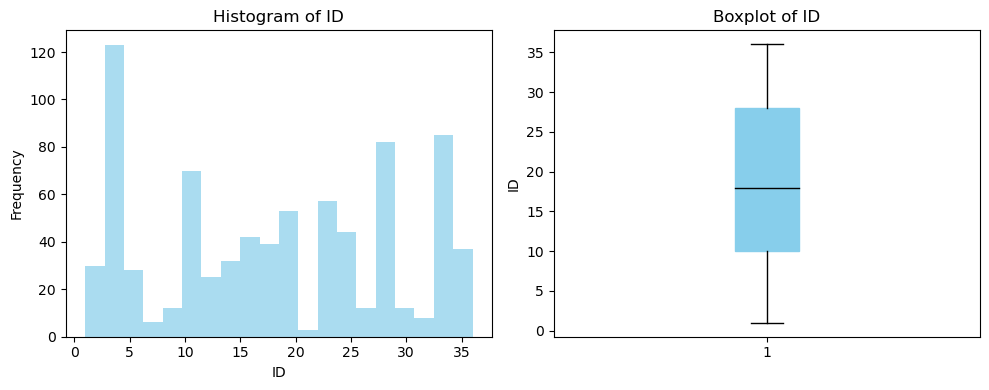

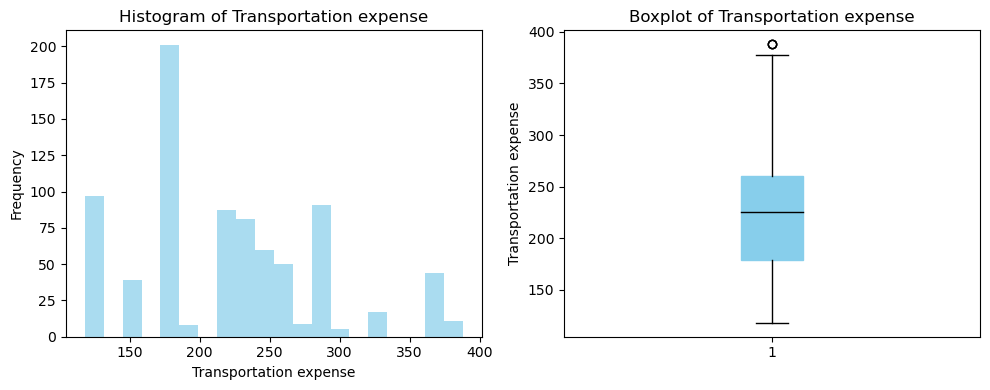

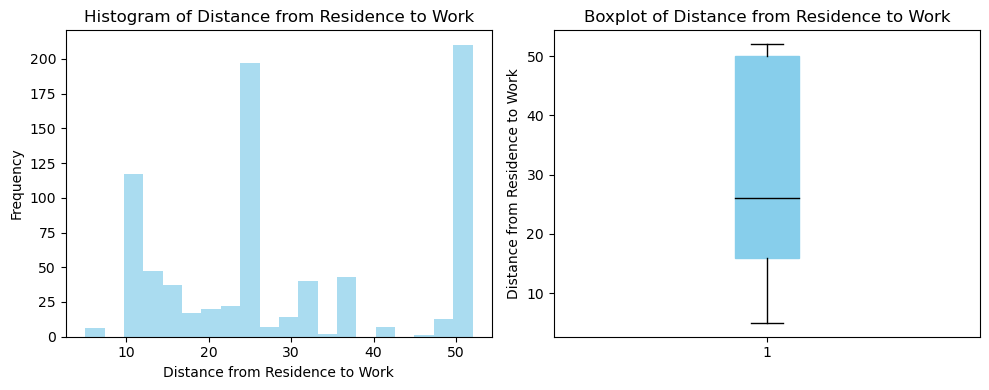

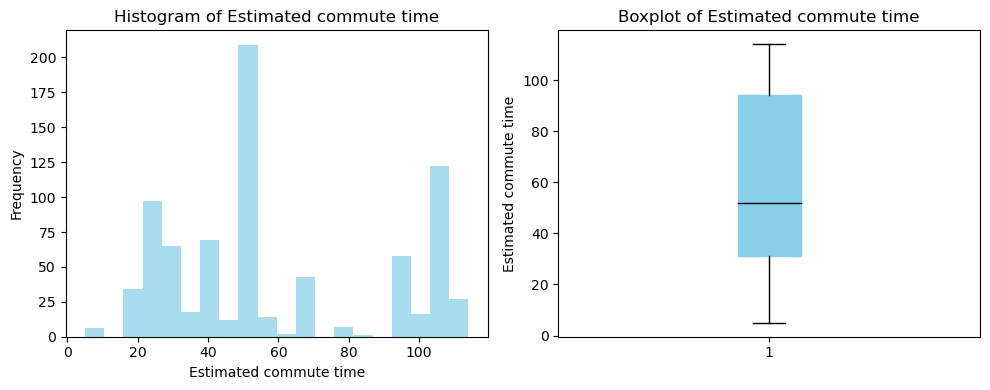

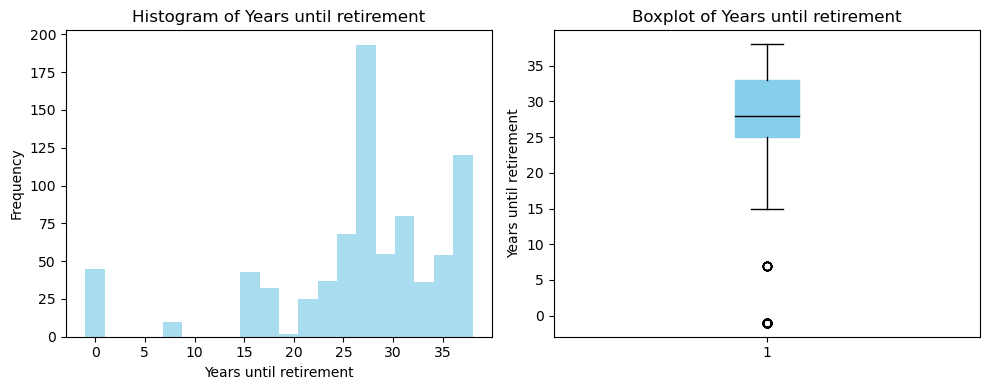

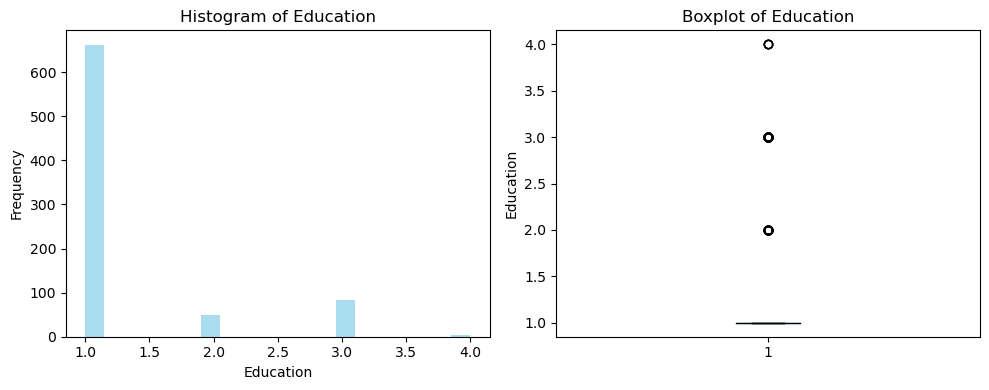

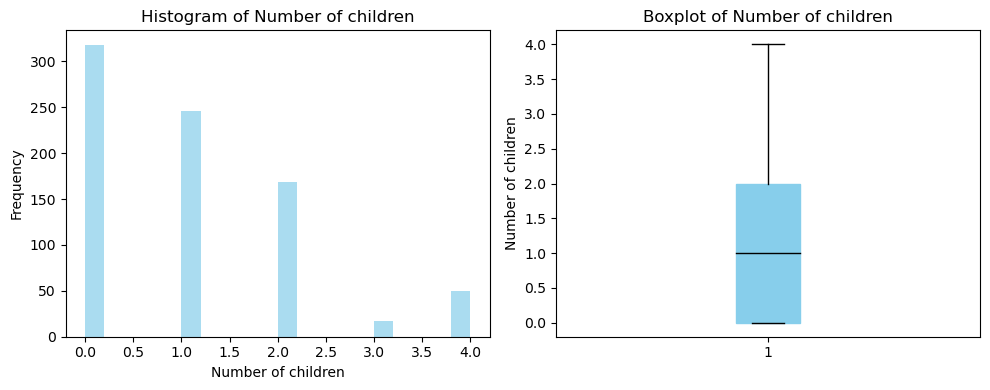

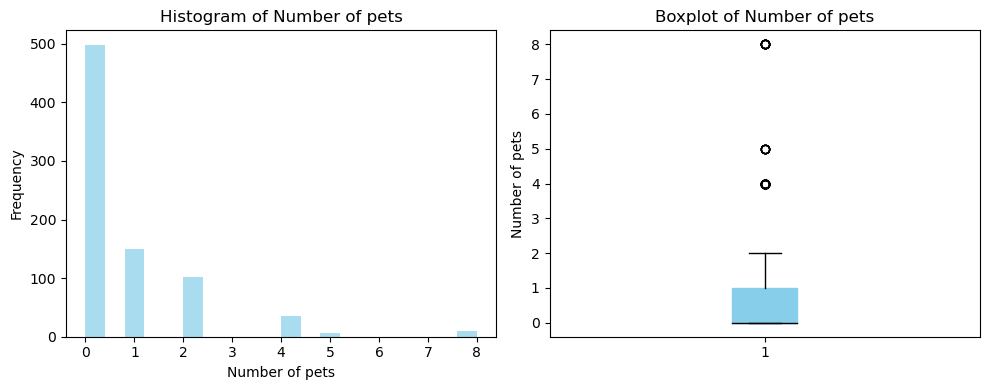

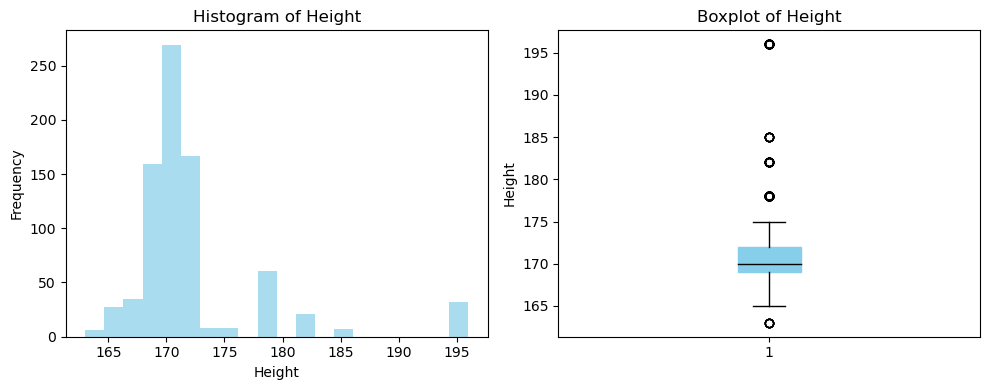

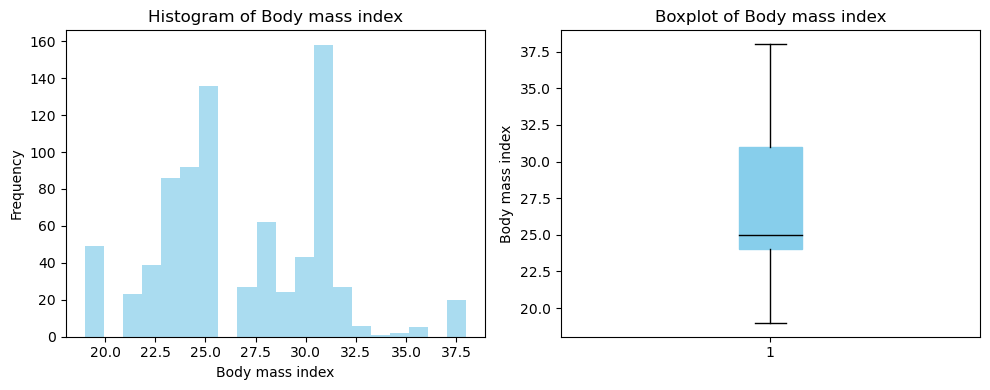

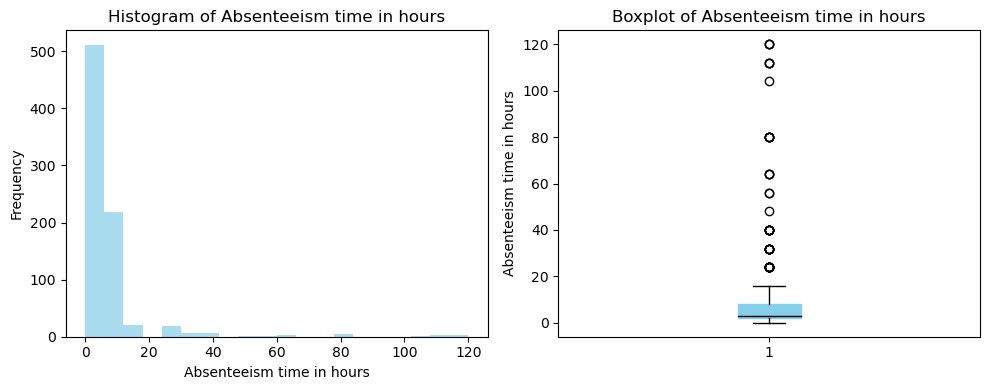

In [17]:
def plot_hist_and_box(df, bins=20, figsize=(10, 4), color='skyblue', alpha=0.7):
    """
    Plots a histogram and a boxplot side by side for each numeric column in a DataFrame.
    """
    num_df = df.select_dtypes(include='number')
    if num_df.empty:
        print("No numeric columns found.")
        return

    for col in num_df.columns:
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Histogram
        axes[0].hist(df[col].dropna(), bins=bins, color=color, alpha=alpha)
        axes[0].set_title(f'Histogram of {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Frequency')
        axes[0].grid(False)

        # Boxplot
        axes[1].boxplot(df[col].dropna(), vert=True, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color='black'))
        axes[1].set_title(f'Boxplot of {col}')
        axes[1].set_ylabel(col)
        axes[1].grid(False)

        plt.tight_layout()
        plt.show()

plot_hist_and_box(abs)

 - theres outliers in: transportation expense, years until retirement, nº pets, height and absentism time in hours
 - education needs to be converted to categorical variable

<a id="1"></a>

### **2.6. Findings in the Categorical Data <font>**

### Summary of Categorical Features

- **Reason for absence:** 28 categories; most common is *Medical consultation* (149 cases). Indicates diverse reasons for absences, but highly imbalanced distribution.  
- **Month of absence:** 12 unique values; *March* is the most frequent (87). Absences may show seasonal trends.  
- **Day of the week:** 6 unique days; *Monday* dominates (159) — consistent with common absenteeism patterns.  
- **Seasons:** 4 categories; *Spring* most common (155), but ~28% missing values — to be reconstructed later.  
- **Service time:** 19 unique values; *18 years* appears most (150). Suggests a workforce with a broad range of tenure.  
- **Date of Birth:** 36 unique values; likely shared birthdays (e.g., placeholder entries). Will be transformed into **Age**.  
- **Disciplinary failure:** Binary; mostly *No* (94.5%) — very few policy violations.  
- **Social drinker / Social smoker:** Both binary with inconsistent labels (“Yes”/“Y”/“No”). Most are *non-smokers (93%)* and *social drinkers (46%)*.  
- **Weight:** 27 unique values; *89 kg* most frequent (110). Needs type correction (`object` → numeric).

#### Key Takeaways
- Some categorical variables (e.g., **Reason for absence**) have many levels — may need **encoding or grouping** before clustering.  
- Binary variables (**Disciplinary failure**, **Smoker/Drinker**) require **label cleaning** for consistency.  
- **Seasons** and **Date of Birth** need transformation during **feature engineering**.  
- Features like **Day of the week** and **Month of absence** may capture **temporal absenteeism trends**.


In [18]:
abs.describe(include = ['O']).T

,count,unique,top,freq
Reason for absence,740,28,Medical consultation,149
Month of absence,737,12,March,87
Day of the week,740,6,Monday,159
Seasons,573,4,Spring,155
Service time,772,18,18,150
Date of Birth,800,36,1987-04-08,122
Disciplinary failure,800,2,No,756
Social drinker,800,3,Yes,367
Social smoker,800,3,No,744
Weight,723,26,89,110


most frequent reason for absence is medical consultation

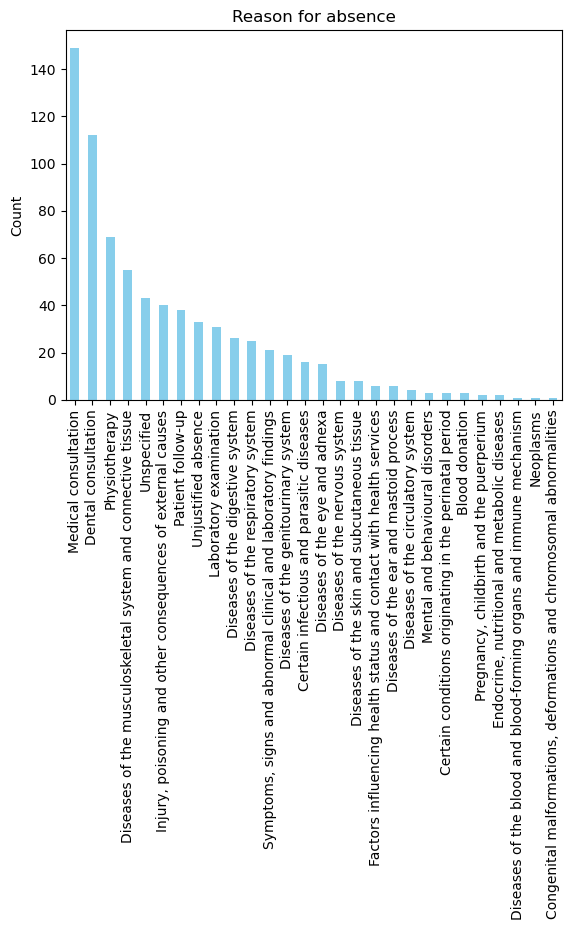

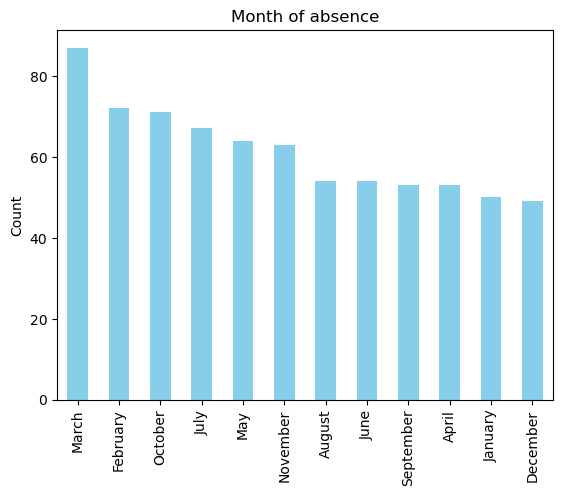

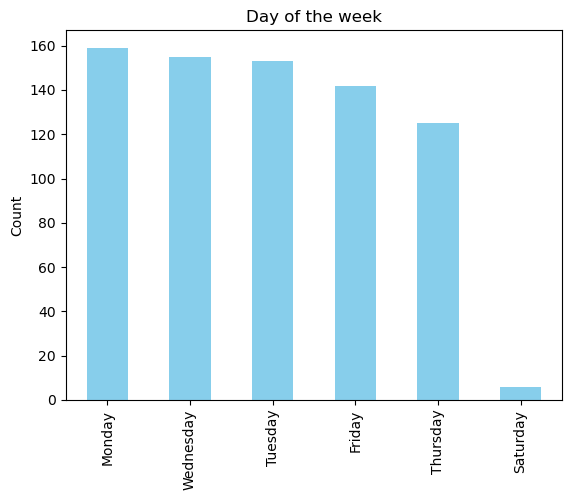

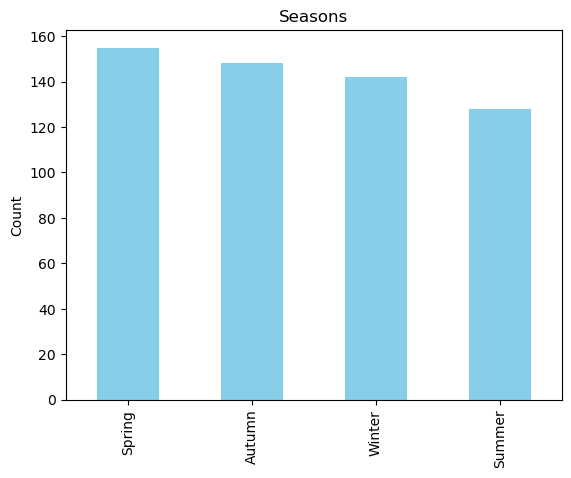

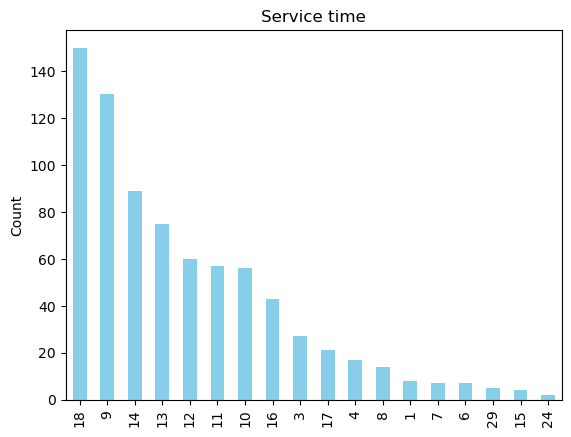

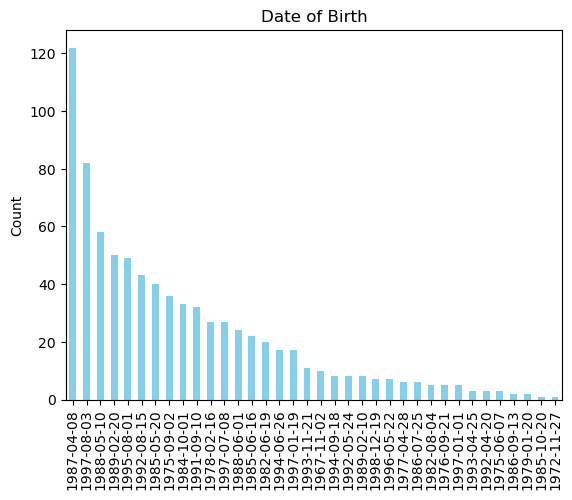

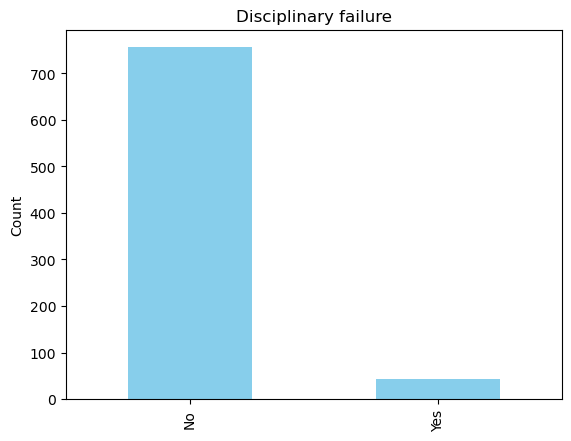

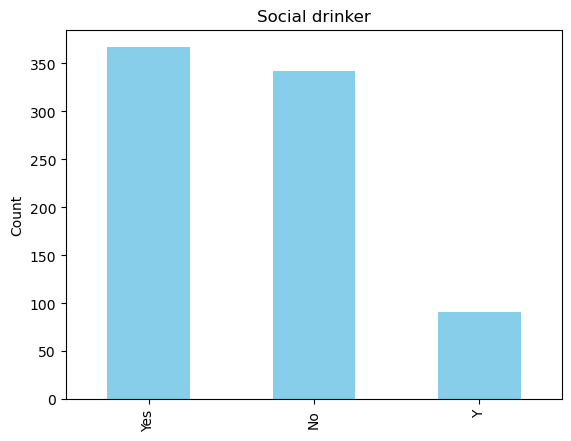

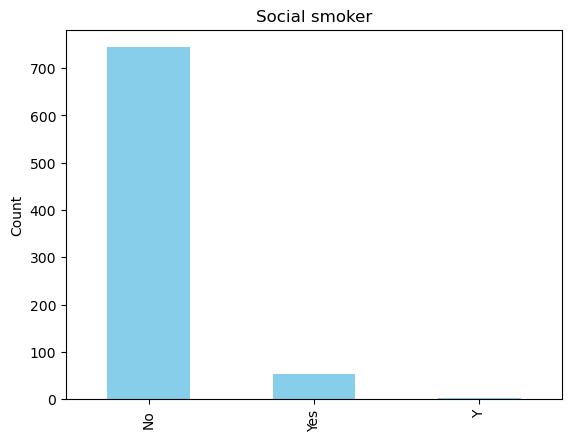

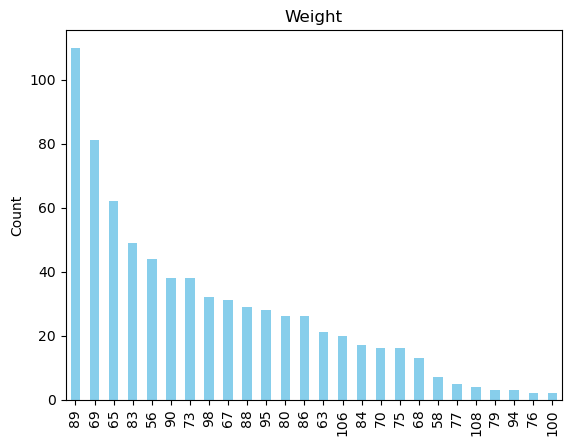

In [19]:
def plot_categorical_barcharts(df, top_n=None):
    """Plot bar charts for all categorical columns."""
    cat_cols = df.select_dtypes(exclude='number').columns
    for col in cat_cols:
        counts = df[col].value_counts().head(top_n) if top_n else df[col].value_counts()
        counts.plot(kind='bar', color='skyblue')
        plt.title(col)
        plt.ylabel('Count')
        plt.grid(False)
        plt.show()

plot_categorical_barcharts(abs)

<a id="1"></a>

### **2.7. Duplicates <font>**

In [20]:
abs[abs.duplicated(keep=False)]

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,Years until retirement,Date of Birth,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours
6,10,Patient follow-up,July,Friday,Summer,361,52,114,3,37,1997-07-08,No,1,1,Yes,No,4,80,172,27,8
11,20,NaN,NaN,NaN,NaN,260,50,94,11,29,1989-02-20,No,1,4,Yes,No,0,65,168,23,8
13,20,NaN,NaN,NaN,NaN,260,50,94,11,29,1989-02-20,No,1,4,Yes,No,0,65,168,23,8
68,3,NaN,NaN,NaN,NaN,179,51,108,18,27,1987-04-08,No,1,0,Y,No,0,89,170,31,3
69,34,Medical consultation,October,Tuesday,Spring,118,10,22,10,28,1988-05-10,No,1,0,No,No,0,83,172,28,3
74,34,Medical consultation,October,Tuesday,Spring,118,10,22,10,28,1988-05-10,No,1,0,No,No,0,83,172,28,3
113,10,Patient follow-up,December,Wednesday,NaN,361,52,114,3,37,1997-07-08,No,1,1,Yes,No,4,80,172,27,8
116,28,Medical consultation,December,Tuesday,Spring,225,26,50,9,37,1997-08-03,No,1,1,No,No,2,69,169,24,2
117,10,Patient follow-up,December,Wednesday,NaN,361,52,114,3,37,1997-07-08,No,1,1,Yes,No,4,80,172,27,8
130,28,NaN,NaN,NaN,NaN,225,26,50,9,37,1997-08-03,No,1,1,No,No,2,69,169,24,1


<a id="1"></a>

# **3. Feature Engineering and Transformation<font>**



<span style="color:red">IMPORTANTE, ADICIONAR TRATAMENTO DE OUTLIERS</span>.

In [21]:
Age = (datetime.today().year - pd.to_datetime(abs['Date of Birth']).dt.year)

abs.insert(loc=1, column='Age', value=Age)

In [22]:
abs = abs.drop(columns=['Date of Birth'])

In [35]:
abs.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,800.0,17.98500,10.952156,1.0,10.0,18.0,28.0,36.0
Age,800.0,36.39750,6.527461,27.0,31.0,37.0,40.0,58.0
Transportation expense,800.0,221.92750,66.778732,118.0,179.0,225.0,260.0,388.0
Distance from Residence to Work,800.0,29.79875,14.875057,5.0,16.0,26.0,50.0,52.0
Estimated commute time,800.0,59.34875,31.301067,5.0,31.0,52.0,94.0,114.0
Years until retirement,800.0,26.74250,9.269498,-1.0,25.0,28.0,33.0,38.0
Number of children,800.0,1.04375,1.120672,0.0,0.0,1.0,2.0,4.0
Number of pets,800.0,1.04375,1.120672,0.0,0.0,1.0,2.0,4.0
Height,800.0,172.09375,6.058122,163.0,169.0,170.0,172.0,196.0
Body mass index,800.0,26.64125,4.267354,19.0,24.0,25.0,31.0,38.0


<a id="1"></a>

### **3.1 Handle identified outliers <font>**


<a id="1"></a>

### **3.2 Handle identified duplicate values<font>**

Upon observation, the rows identified as duplicates can legitimatly represent abscenses reported for the same worker in different days of a given month.

This happens due to the present granularity, the bottom of the date hierarchy ends in "month", so there is no way to identify if 2 given abscences (rows) take place in different days.

Considering this, duplicate rows will be kept.

<a id="1"></a>

### **3.3 Feature transformation<font>**
Standardize and unify known features

<a id="1"></a>

#### **3.3.1 Standardize binary columns<font>**


Change all columns where values are "Yes" or "No" to a numerical value.

From now on: "Yes" / "Y" = 1, "No" = 0

In [23]:
def binary_standardize(column):
    """Standardize binary columns to 0 and 1.
    Args:
        column (pd.Series): A pandas Series containing binary values as 'Yes'/'No' or 'Y'/'N'.
        Returns:
        column (pd.Series): A pandas Series with binary values standardized to 0 and 1. """
    column = column.replace({'Yes': 1, 'No': 0, 'Y': 1, 'N': 0})
    return column.astype(int)

In [24]:
modded_abs = abs.copy()

# Apply the function to all columns
for col in abs.columns:
    
    values = ['Y', 'N', 'Yes', 'No']

    if set(abs[col].unique()).issubset(values):
        modded_abs[col] = binary_standardize(abs[col])   


<a id="1"></a>

#### **3.3.2 Re-format numerical and date-type columns<font>**


Identify and handle all columns with exclusive numerical or datetime values currently being handled as objects

In [25]:
#try to convert numerical columns stored as objects to numeric dtype
for col in modded_abs.select_dtypes(include=['object']).columns:
    try:
        #convert to integers
        modded_abs[col] = pd.to_numeric(modded_abs[col], downcast='integer')
        print(f"Column {col} converted to numeric.")
    except ValueError:
        print(f"Column {col} could not be converted to numeric.")
    

Column Reason for absence could not be converted to numeric.
Column Month of absence could not be converted to numeric.
Column Day of the week could not be converted to numeric.
Column Seasons could not be converted to numeric.
Column Service time converted to numeric.
Column Weight converted to numeric.


In [26]:
#try to conver date columns stored as object to datetime dtype
for col in modded_abs.select_dtypes(include=['object']).columns:
    try:
        modded_abs[col] = pd.to_datetime(modded_abs[col])
        print(f"Column {col} converted to datetime.")
    except ValueError:
        print(f"Column {col} could not be converted to datetime.")

Column Reason for absence could not be converted to datetime.
Column Month of absence could not be converted to datetime.
Column Day of the week could not be converted to datetime.
Column Seasons could not be converted to datetime.


<a id="1"></a>

#### **3.3.3 Standardize missing values to nan<font>**


Take all missing values set to -1 and convert to Nan

In [27]:
#replace -1 with NaN
modded_abs = modded_abs.replace(-1, np.nan)

<a id="1"></a>

### **3.4 Handle Identified missing values<font>**
Considering that both numerical and categorical columns have missing values, 2 methods were employed:

- a KNN imputer for numerical values
- A Simple imputer, considering the most frequent values, for categorical columns



<span style="color:red">Placeholder</span>.

In [28]:
from sklearn.impute import SimpleImputer

# select features automatically from the existing dataframe
numeric_features = modded_abs.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = modded_abs.select_dtypes(include=['object', 'category']).columns.tolist()

# Important: avoid using ColumnTransformer that concatenates differently-typed outputs
# into a single ndarray (which can cause DTypePromotionError when mixing datetimes).
# Instead, impute numeric and categorical columns separately and then concat.

# 1) Numeric imputation with KNNImputer
num_imputer = KNNImputer(n_neighbors=2)
numeric_array = num_imputer.fit_transform(modded_abs[numeric_features])
num_df = pd.DataFrame(numeric_array, columns=numeric_features, index=modded_abs.index)

# Restore integer dtypes where reasonable (KNNImputer returns floats)
for col in numeric_features:
    if pd.api.types.is_integer_dtype(modded_abs[col].dtype):
        num_df[col] = pd.to_numeric(num_df[col], downcast='integer')
    else:
        num_df[col] = pd.to_numeric(num_df[col], errors='coerce')

# 2) Categorical imputation with SimpleImputer
cat_imputer = SimpleImputer(strategy="most_frequent")
if categorical_features:
    cat_array = cat_imputer.fit_transform(modded_abs[categorical_features])
    cat_df = pd.DataFrame(cat_array, columns=categorical_features, index=modded_abs.index)
else:
    cat_df = pd.DataFrame(index=modded_abs.index)

# 3) Remainder columns (e.g., datetime) - keep as-is
remainder_cols = [c for c in modded_abs.columns if c not in (numeric_features + categorical_features)]
remainder_df = modded_abs[remainder_cols].copy()

# 4) Concatenate in the original column order
all_cols = numeric_features + categorical_features + remainder_cols
imputed_df = pd.concat([num_df, cat_df, remainder_df], axis=1)[all_cols]

imputed_df.head()

,ID,Age,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,Years until retirement,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours,Reason for absence,Month of absence,Day of the week,Seasons
0,11,33,289,36,69,13.0,32.0,0,1,2,1,0,1,90.0,172,30,4,Unjustified absence,July,Tuesday,Summer
1,36,50,118,13,26,18.0,15.0,1,1,1,1,0,0,98.0,178,31,0,Unspecified,July,Tuesday,Spring
2,3,38,179,51,108,18.0,27.0,0,1,0,1,0,0,89.0,170,31,2,Medical consultation,July,Wednesday,Summer
3,7,39,279,5,5,14.0,26.0,0,1,2,1,1,0,68.0,168,24,4,Diseases of the eye and adnexa,July,Thursday,Spring
4,11,33,289,36,69,13.0,32.0,0,1,2,1,0,1,90.0,172,30,2,Medical consultation,July,Thursday,Summer


In [29]:
abs['Age'] = abs['Age'].astype('int16')
abs['Transportation expense'] = abs['Transportation expense'].astype('int32')
abs['Distance from Residence to Work'] = abs['Distance from Residence to Work'].astype('int32')
abs['Estimated commute time'] = abs['Estimated commute time'].astype('int32')
# abs['Service time'] = abs['Service time'].astype('int32')
abs['Years until retirement'] = abs['Years until retirement'].astype('int32')
abs['Education'] = abs['Education'].astype('object')
abs['Number of children'] = abs['Number of children'].astype('int8')
abs['Number of pets'] = abs['Number of children'].astype('int8')
# abs['Weight'] = abs['Weight'].astype('int32')
# abs['Height'] = abs['Weight'].astype('int32')
abs['Absenteeism time in hours'] = abs['Absenteeism time in hours'].astype('int32')

<a id="1"></a>

### **3.5 Feature Engineering and selection<font>**


Construct and select variables to be presented in the Worker-first table

<a id="1"></a>

#### **3.5.1 One hot enconding<font>**
Enconding  Reasons for abscence with One Hot Encoding

In [30]:
#One hot encoding to 1 or 0

OHE_abs = pd.concat([imputed_df, pd.get_dummies(imputed_df["Reason for absence"], prefix="Reason", drop_first=True).astype(int)], axis=1)

<a id="1"></a>

#### **3.5.2 Feature Selection<font>**

<a id="1"></a>

### **3.6 Worker-first table<font>**

Create a worker based dataframe where:

- rows are grouped by worker ID
- Abseentism related data is summed
- Demographic variables are, in case of discrepancies, described by the most common value
- highest number of consecutive dates is presented

In [31]:
#define demographic columns and absence related columns
demographic_cols =[
       'Transportation expense', 'Distance from Residence to Work',
       'Estimated commute time', 'Service time', 'Years until retirement',
       'Age',  'Education',
       'Number of children', 'Social drinker', 'Social smoker',
       'Number of pets', 'Weight', 'Height', 'Body mass index']

absence_cols = [col for col in OHE_abs.columns if col not in demographic_cols]
absence_cols

['ID',
 'Disciplinary failure',
 'Absenteeism time in hours',
 'Reason for absence',
 'Month of absence',
 'Day of the week',
 'Seasons',
 'Reason_Certain conditions originating in the perinatal period',
 'Reason_Certain infectious and parasitic diseases',
 'Reason_Congenital malformations, deformations and chromosomal abnormalities',
 'Reason_Dental consultation',
 'Reason_Diseases of the blood and blood-forming organs and immune mechanism',
 'Reason_Diseases of the circulatory system',
 'Reason_Diseases of the digestive system',
 'Reason_Diseases of the ear and mastoid process',
 'Reason_Diseases of the eye and adnexa',
 'Reason_Diseases of the genitourinary system',
 'Reason_Diseases of the musculoskeletal system and connective tissue',
 'Reason_Diseases of the nervous system',
 'Reason_Diseases of the respiratory system',
 'Reason_Diseases of the skin and subcutaneous tissue',
 'Reason_Endocrine, nutritional and metabolic diseases',
 'Reason_Factors influencing health status and co

In [32]:
def group_by_worker(dataframe):
    ''' Created a dataframe grouped by worker ID, aggregating demographic columns by taking the first value,
    summing one-hot encoded reason columns, and calculating count, sum, and mean for absence-related metrics.
    Args:
        dataframe (pd.DataFrame): Input dataframe with worker ID as index.
    Returns:
        pd.DataFrame: Grouped dataframe by worker ID with aggregated values. '''
    # Define base aggregation dictionary for demographic columns
    agg_dict = {
        # Demographic columns (take first value)
        'Transportation expense': 'first',
        'Distance from Residence to Work': 'first',
        'Estimated commute time': 'first',
        'Service time': 'first',
        'Years until retirement': 'first',
        'Age': 'first',
        'Education': 'first',
        'Number of children': 'first',
        'Social drinker': 'first',
        'Social smoker': 'first',
        'Number of pets': 'first',
        'Weight': 'first',
        'Height': 'first',
        'Body mass index': 'first',
        
        # Absence-related metrics
        'Absenteeism time in hours': ['count', 'sum', 'mean'],
        'Disciplinary failure': 'sum'
    }
    
    # Add aggregation for all one-hot encoded reason columns
    reason_columns = [col for col in dataframe.columns if col.startswith('Reason_')]
    for col in reason_columns:
        agg_dict[col] = 'sum'
    
    # Group by worker ID and aggregate
    grouped = dataframe.groupby(level=0).agg(agg_dict)
    
    # Flatten column names if they became multi-index
    if isinstance(grouped.columns, pd.MultiIndex):
        grouped.columns = [f"{col[0]}_{col[1]}" if col[1] != 'first' else col[0] 
                         for col in grouped.columns]
    
    return grouped
    


worker_df = group_by_worker(OHE_abs)
type(worker_df)

pandas.core.frame.DataFrame

In [33]:
worker_df

,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,Years until retirement,Age,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours_count,Absenteeism time in hours_sum,Absenteeism time in hours_mean,Disciplinary failure_sum,Reason_Certain conditions originating in the perinatal period_sum,Reason_Certain infectious and parasitic diseases_sum,"Reason_Congenital malformations, deformations and chromosomal abnormalities_sum",Reason_Dental consultation_sum,Reason_Diseases of the blood and blood-forming organs and immune mechanism_sum,Reason_Diseases of the circulatory system_sum,Reason_Diseases of the digestive system_sum,Reason_Diseases of the ear and mastoid process_sum,Reason_Diseases of the eye and adnexa_sum,Reason_Diseases of the genitourinary system_sum,Reason_Diseases of the musculoskeletal system and connective tissue_sum,Reason_Diseases of the nervous system_sum,Reason_Diseases of the respiratory system_sum,Reason_Diseases of the skin and subcutaneous tissue_sum,"Reason_Endocrine, nutritional and metabolic diseases_sum",Reason_Factors influencing health status and contact with health services_sum,"Reason_Injury, poisoning and other consequences of external causes_sum",Reason_Laboratory examination_sum,Reason_Medical consultation_sum,Reason_Mental and behavioural disorders_sum,Reason_Neoplasms_sum,Reason_Patient follow-up_sum,Reason_Physiotherapy_sum,"Reason_Pregnancy, childbirth and the puerperium_sum","Reason_Symptoms, signs and abnormal clinical and laboratory findings_sum",Reason_Unjustified absence_sum,Reason_Unspecified_sum
0,289,36,69,13.0,32.0,33,1,2,1,0,1,90.0,172,30,1,4,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,118,13,26,18.0,15.0,50,1,1,1,0,0,98.0,178,31,1,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,179,51,108,18.0,27.0,38,1,0,1,0,0,89.0,170,31,1,2,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,279,5,5,14.0,26.0,39,1,2,1,1,0,68.0,168,24,1,4,4.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,289,36,69,13.0,32.0,33,1,2,1,0,1,90.0,172,30,1,2,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,289,36,69,13.0,32.0,33,1,2,1,0,1,90.0,172,30,1,8,8.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
796,235,11,20,14.0,28.0,37,3,1,0,0,1,88.0,172,29,1,4,4.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
797,118,14,34,13.0,25.0,40,1,1,1,0,8,98.0,170,34,1,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
798,231,35,63,14.0,26.0,39,1,2,1,0,2,100.0,170,35,1,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


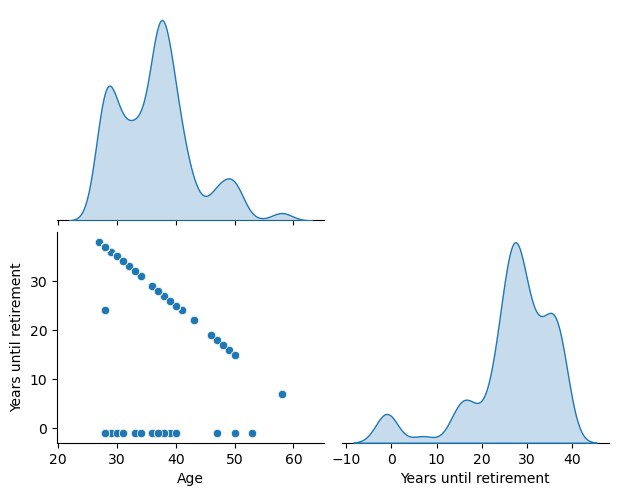

In [34]:
# Select the columns for the pair plot
x = ['Age', 'Years until retirement']
# Create the pair plot
sns.pairplot(abs[x], kind='scatter',  diag_kind='kde', corner=True, aspect=1.25)
# Display the plot
plt.show()

In [ ]:
abs[abs['Years until retirement']<0]

In [ ]:
abs.drop(abs[abs['Years until retirement']<0].index , inplace= True)
abs

In [ ]:
# Select the columns for the pair plot
x = ['Age', 'Service time']
# Create the pair plot
sns.pairplot(abs[x], kind='scatter',  diag_kind='kde', corner=True, aspect=1.25)
# Display the plot
plt.show()